In [30]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
#распаковка датасета из 21000 изображений, 15 классов - каждый по 1400 изображений 224х224. 70% train, 15% validation, 15% test.
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab/vegs_dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/vegs_dataset')

In [33]:
path = '/content/vegs_dataset/Vegetable Images'

print(os.listdir(path))

['train', 'test', 'validation']


In [34]:
train_dir = '/content/vegs_dataset/Vegetable Images/train'
val_dir = '/content/vegs_dataset/Vegetable Images/validation'
test_dir = '/content/vegs_dataset/Vegetable Images/test'

In [35]:
classes = ('Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 
           'Cauliflower', 'Cucumber', 'Papaya',  'Potato', 'Pumpkin',  'Radish',  'Tomato')

In [36]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # нормализация изображения под resnet18 согласно документации pytorch

train_set = torchvision.datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=0, shuffle=True)

val_set = torchvision.datasets.ImageFolder(val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=0, shuffle=True)

test_set = torchvision.datasets.ImageFolder(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=0, shuffle=True)

In [37]:
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image.permute(1, 2, 0).numpy() * std + mean
        plt.imshow(image.clip(0, 1))
    print("Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))

Labels:  Tomato Bitter_Gourd Capsicum Bottle_Gourd


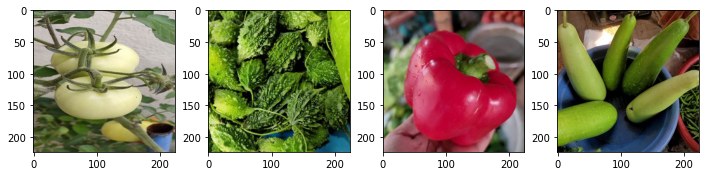

In [38]:
images, labels = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

image_shower(images, labels)

In [39]:
model = torchvision.models.resnet18(pretrained=True) # загрузка предобученной сети

In [40]:
for param in model.parameters(): # заморозка параметров
    param.require = False

model.fc = nn.Linear(model.fc.in_features, 15) # 512 нейронов на входе, на выходе - 15

model.to(device) # перенос модели на GPU

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [42]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                model.train()  # установка режима обучения
            else:
                dataloader = val_loader
                model.eval()   # установка режима валидации

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):  # перенос батчей на GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # сброс накопленного градиента

                with torch.set_grad_enabled(phase == 'train'): # получение предсказаний и ошибки
                  preds = model(inputs)
                  loss_value = loss(preds, labels)
                  preds_class = preds.argmax(dim=1)
                  

                    
                  if phase == 'train': # подсчет градиента и обновление весов в режиме обучения
                      loss_value.backward()
                      optimizer.step()
                      scheduler.step()

                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model 

In [43]:
train_model(model, loss, optimizer, scheduler, num_epochs=2) # запуск обучения

Epoch 0/1:


100%|██████████| 235/235 [1:01:30<00:00, 15.70s/it]

train Loss: 0.2011 Acc: 0.9479



100%|██████████| 47/47 [04:05<00:00,  5.22s/it]

val Loss: 0.1336 Acc: 0.9637
Epoch 1/1:



100%|██████████| 235/235 [1:02:34<00:00, 15.98s/it]

train Loss: 0.1689 Acc: 0.9574



100%|██████████| 47/47 [04:08<00:00,  5.29s/it]

val Loss: 0.1361 Acc: 0.9653


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Labels:  Cucumber Papaya Capsicum Pumpkin
Predicted:  Cucumber Papaya Capsicum Pumpkin


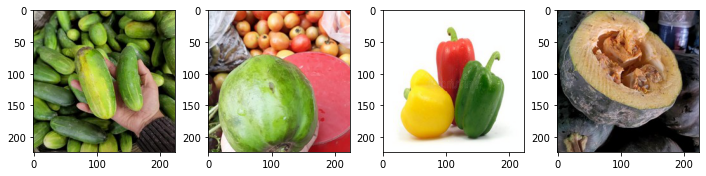

In [45]:
# получение предсказаний на тестовом датасете
model.eval()
images, labels = next(iter(test_loader))
image_shower(images, labels)

preds = model(images.to(device))

_, predicted = torch.max(preds, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))